## Sources
1. [The Inference Button: Bayesian GLMs made easy with PyMC3](https://twiecki.io/blog/2013/08/12/bayesian-glms-1/)
2. [This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](https://twiecki.io/blog/2013/08/27/bayesian-glms-2/)  
3. [The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/)
4. [MCMC sampling for dummies](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)

# Post 1 - *The Inference Button: Bayesian GLMs made easy with PyMC3*

### Bayesian Formulation of Linear Regression

$$
 Y \sim \mathcal{N}(X\beta, \sigma^2)
$$

where:  
$\beta$ - linear fitting coeficient  
$\sigma^2$ - variance


Advantages of Bayesian approach:
- **Priors**: put priors accordingly in parameters (lower, higher)
- **Uncertainty**: we can get a complete posterior distribution on how likely each different value of $\beta$

In [1]:
%matplotlib inline
from pymc3 import *
import numpy as np
import matplotlib.pyplot as plt

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
size = 200
true_intercept = 1
true_slope = -1
x = np.linspace(0, 1, size)

In [3]:
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)
# add noise
data = dict(x=x, y=y)

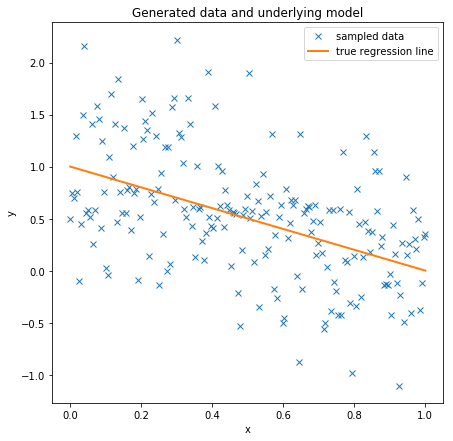

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

## Bayesian Model

In [5]:
with Model() as model:
    sigma = HalfCauchy('sigma', beta=10, testval=1.)
    intercept = Normal('Intercept', 0, sd=20)
    x_coeff = Normal('x', 0, sd=20)
    ## Likelihood
    likelihood = Normal('y', mu=intercept + x_coeff * x, 
                        sd=sigma, observed=y)
    # Inference!
    trace = sample(progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x, Intercept, sigma_log__]
100%|██████████| 1000/1000 [00:01<00:00, 564.54it/s]
INFO (theano.gof.compilelock): Waiting for existing lock by process '49849' (I am process '49850')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/rsilvei/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '49849' (I am process '49851')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/rsilvei/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
INFO (theano.gof.compilelock): Waiting for existing lock by process '49850' (I am process '49851')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/rsilvei/.theano/compiledir_Darwin-18.7.0-x86_64-i386-64bit-i386-3.6.5-64/lock_dir
The acceptance probability

In [6]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    GLM.from_formula('y ~ x', data)
    trace = sample(progressbar=True, njobs=5) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [sd_log__, x, Intercept]
100%|██████████| 1000/1000 [00:01<00:00, 581.99it/s]
The acceptance probability does not match the target. It is 0.8900819919188973, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8881246518613716, but should be close to 0.8. Try to increase the number of tuning steps.


/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 504x504 with 0 Axes>

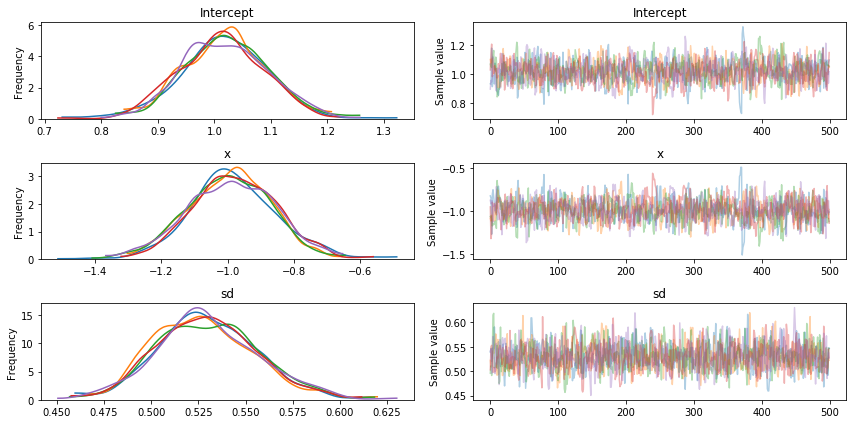

In [7]:
plt.figure(figsize=(7, 7))
traceplot(trace)
plt.tight_layout();

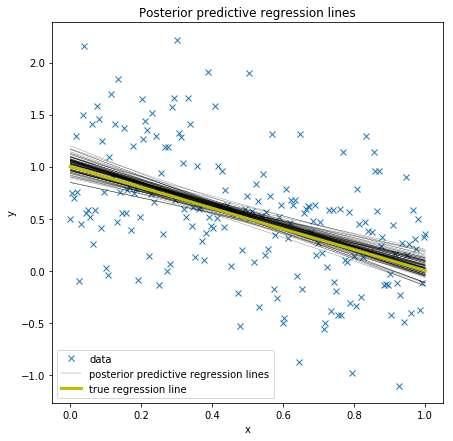

In [8]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plots.plot_posterior_predictive_glm(trace, samples=100, 
                                    label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

Text(0, 0.5, 'y')

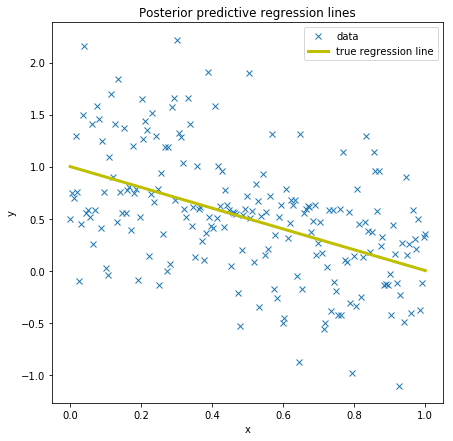

In [9]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')
plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')

# Post 2 - *This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3*

In [10]:
%matplotlib inline

import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import theano

In [11]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

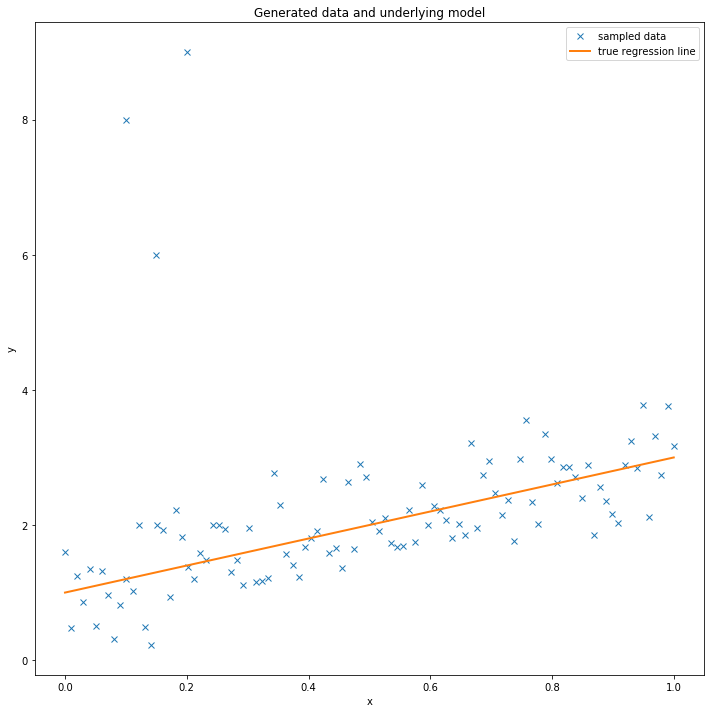

In [12]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x_out, y_out, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

In [13]:
with pm.Model() as model:
    pm.GLM.from_formula('y ~ x', data)
    trace = pm.sample(progressbar=False, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd_log__, x, Intercept]
The acceptance probability does not match the target. It is 0.8858850282926803, but should be close to 0.8. Try to increase the number of tuning steps.


In [14]:
len(trace)

500

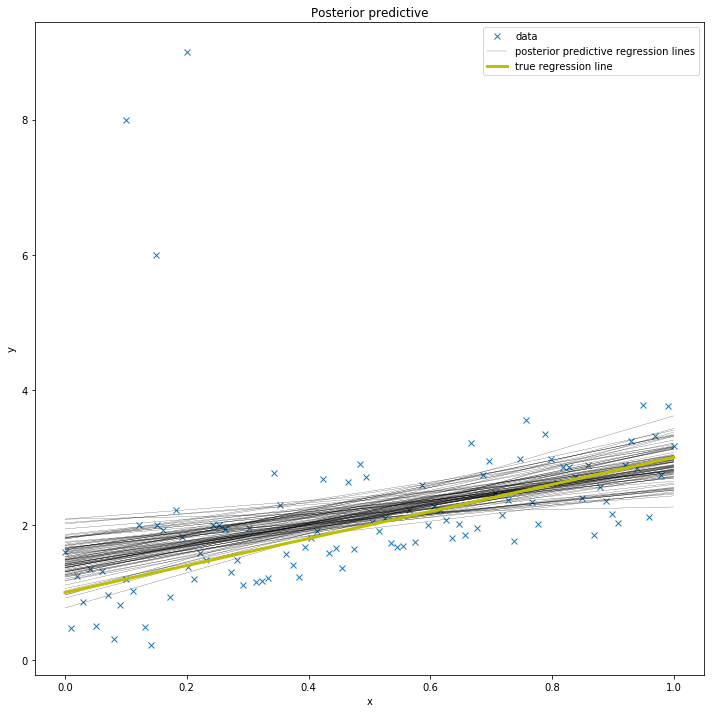

In [15]:
plt.figure(figsize=(12, 12))
plt.subplot(111, xlabel='x', ylabel='y', 
            title='Posterior predictive regression lines')
plt.plot(x_out, y_out, 'x', label='data')
pm.plots.plot_posterior_predictive_glm(trace, samples=100, 
                                 label='posterior predictive regression lines')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')

plt.legend(loc=0);

In [16]:
normal_dist = pm.Normal.dist(mu=0, sd=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)

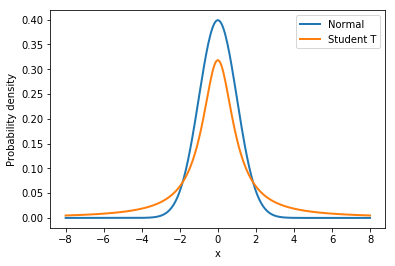

In [17]:
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend();

In [18]:
with pm.Model() as model_robust:
    family = pm.glm.families.StudentT()
    pm.GLM.from_formula('y ~ x', data, family=family)
    trace_robust = pm.sample(progressbar=False, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam_log__, x, Intercept]


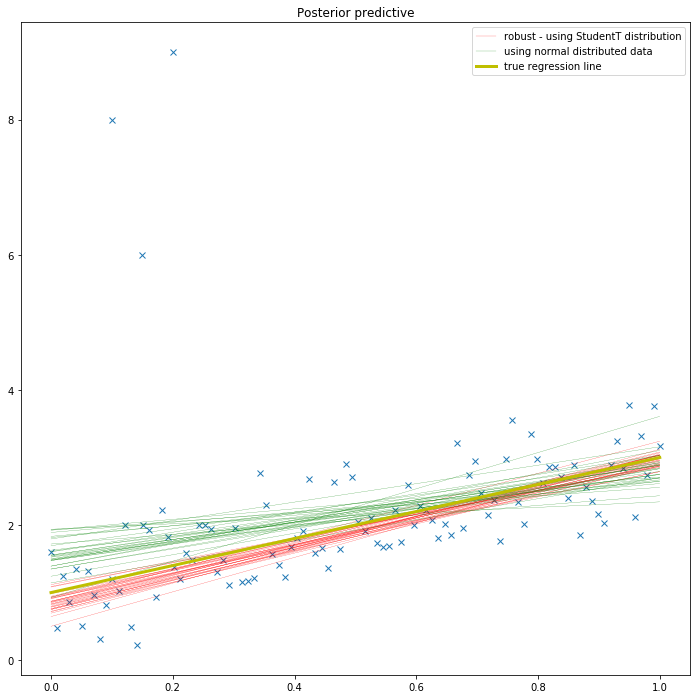

In [19]:
plt.figure(figsize=(12, 12))
plt.plot(x_out, y_out, 'x')
pm.plots.plot_posterior_predictive_glm(trace_robust,
                                       label='robust - using StudentT distribution',
                                       c='r')
pm.plots.plot_posterior_predictive_glm(trace,
                                       label='using normal distributed data',
                                       c='g')
plt.plot(x, true_regression_line, 
         label='true regression line', lw=3., c='y')
plt.legend();

# Post 3 - *The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3*

Sources:  
1. https://twiecki.io/blog/2014/03/17/bayesian-glms-3/  
2. https://nbviewer.jupyter.org/github/fonnesbeck/multilevel_modeling/blob/master/multilevel_modeling.ipynb?create=1  


- Multi-level effect
- Shrinkage effect

One regression fits-all (same for all):
$$ radon_{i,c}  = \alpha + \beta*floor_{i,c}+\epsilon $$

One regression per-county (no similarities shared):
$$ radon_{i,c}  = \alpha_{c} + \beta_{c}*floor_{i,c}+\epsilon_{c} $$

Hierarchical Regression $\rightarrow$ The best of both worlds, assuming that the coeficients $\alpha$ and $\beta$ all came from a common group distribution:
$$ \alpha_{c} \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$ \beta{c} \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)$$



In [35]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd

In [36]:
data = pd.read_csv('radon.csv')
county_names = data.county.unique()
county_idx = data['county_code'].values

In [37]:
data[['county', 'log_radon', 'floor']].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


In [38]:
county_names

array(['AITKIN', 'ANOKA', 'BECKER', 'BELTRAMI', 'BENTON', 'BIG STONE',
       'BLUE EARTH', 'BROWN', 'CARLTON', 'CARVER', 'CASS', 'CHIPPEWA',
       'CHISAGO', 'CLAY', 'CLEARWATER', 'COOK', 'COTTONWOOD', 'CROW WING',
       'DAKOTA', 'DODGE', 'DOUGLAS', 'FARIBAULT', 'FILLMORE', 'FREEBORN',
       'GOODHUE', 'HENNEPIN', 'HOUSTON', 'HUBBARD', 'ISANTI', 'ITASCA',
       'JACKSON', 'KANABEC', 'KANDIYOHI', 'KITTSON', 'KOOCHICHING',
       'LAC QUI PARLE', 'LAKE', 'LAKE OF THE WOODS', 'LE SUEUR',
       'LINCOLN', 'LYON', 'MAHNOMEN', 'MARSHALL', 'MARTIN', 'MCLEOD',
       'MEEKER', 'MILLE LACS', 'MORRISON', 'MOWER', 'MURRAY', 'NICOLLET',
       'NOBLES', 'NORMAN', 'OLMSTED', 'OTTER TAIL', 'PENNINGTON', 'PINE',
       'PIPESTONE', 'POLK', 'POPE', 'RAMSEY', 'REDWOOD', 'RENVILLE',
       'RICE', 'ROCK', 'ROSEAU', 'SCOTT', 'SHERBURNE', 'SIBLEY',
       'ST LOUIS', 'STEARNS', 'STEELE', 'STEVENS', 'SWIFT', 'TODD',
       'TRAVERSE', 'WABASHA', 'WADENA', 'WASECA', 'WASHINGTON',
       'WATONWAN', '

In [41]:
county_name = 'WATONWAN'
c_data = data.ix[data.county == county_name]
c_data = c_data.reset_index(drop=True)
c_log_radon = c_data.log_radon
c_floor_measure = c_data.floor.values

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [44]:
c_data

,Unnamed: 0,idnum,state,state2,stfips,zip,region,typebldg,floor,room,...,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm,county_code,log_radon
0,887,5968.0,MN,MN,27.0,56062,5.0,1.0,0.0,4.0,...,3.3,1088.985661,0.0,0.0,165.0,WATONWAN,27165.0,1.2011,80,2.631889
1,888,5969.0,MN,MN,27.0,56088,5.0,1.0,1.0,4.0,...,3.5,1214.922779,0.0,0.0,165.0,WATONWAN,27165.0,1.2011,80,2.332144
2,889,5970.0,MN,MN,27.0,56120,5.0,1.0,1.0,3.0,...,5.3,1214.922779,0.0,0.0,165.0,WATONWAN,27165.0,1.2011,80,1.757858


In [45]:
indiv_traces = {}
for county_name in county_names:
    # Select subset of data belonging to county
    c_data = data.ix[data.county == county_name]
    c_data = c_data.reset_index(drop=True)

    c_log_radon = c_data.log_radon
    c_floor_measure = c_data.floor.values

    with pm.Model() as individual_model:
        # Intercept prior
        a = pm.Normal('alpha', mu=0, sd=1)
        # Slope prior
        b = pm.Normal('beta', mu=0, sd=1)

        # Model error prior
        eps = pm.HalfCauchy('eps', beta=1)

        # Linear model
        radon_est = a + b * c_floor_measure

        # Data likelihood
        y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=c_log_radon)

        # Inference button (TM)!
        trace = pm.sample(progressbar=False)
        
    indiv_traces[county_name] = trace

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta, alpha]
/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta, alpha]
Auto

NUTS: [eps_log__, beta, alpha]
The acceptance probability does not match the target. It is 0.8792608842837505, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta, alpha]
The acceptance probability does not match the target. It is 0.8820034334651486, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta, alpha]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
I

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta, alpha]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6191377679603097, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta, alpha]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 37 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6511821675349497, but should be close to 0.8. Try to increase the number

In [46]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_a = pm.Normal('mu_alpha', mu=0., sd=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=1)
    mu_b = pm.Normal('mu_beta', mu=0., sd=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta=1)
    
    # Intercept for each county, distributed around group mean mu_a
    a = pm.Normal('alpha', mu=mu_a, sd=sigma_a, shape=len(data.county.unique()))
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal('beta', mu=mu_b, sd=sigma_b, shape=len(data.county.unique()))
    
    # Model error
    eps = pm.HalfCauchy('eps', beta=1)
    
    # Expected value
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [47]:
with hierarchical_model:
    hierarchical_trace = pm.sample(njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps_log__, beta, alpha, sigma_beta_log__, mu_beta, sigma_alpha_log__, mu_alpha]
100%|██████████| 1000/1000 [00:05<00:00, 196.38it/s]
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5892891592831336, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


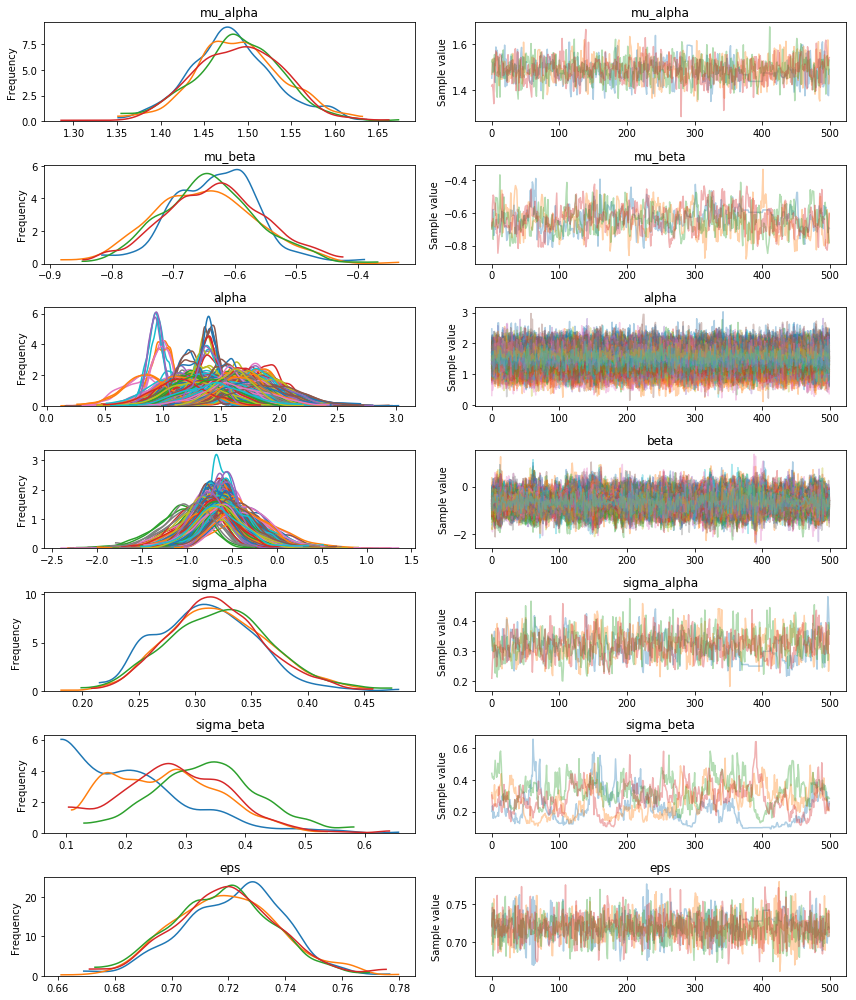

In [48]:
pm.traceplot(hierarchical_trace);

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """


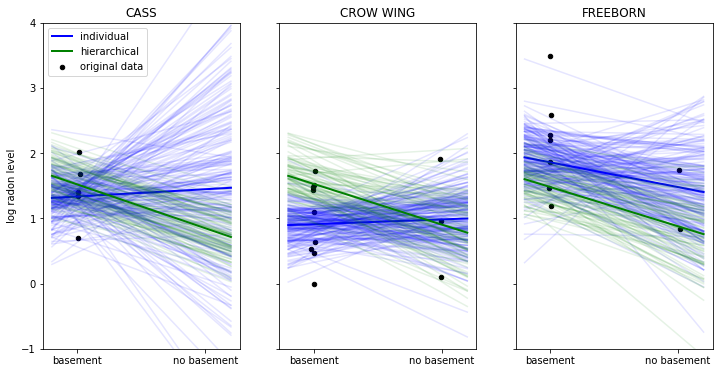

In [49]:
selection = ['CASS', 'CROW WING', 'FREEBORN']
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = data.ix[data.county == c]
    c_data = c_data.reset_index(drop = True)
    z = list(c_data['county_code'])[0]

    xvals = np.linspace(-0.2, 1.2)
    for a_val, b_val in zip(indiv_traces[c]['alpha'][::10], indiv_traces[c]['beta'][::10]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'b', alpha=.1)
    axis[i].plot(xvals, indiv_traces[c]['alpha'][::10].mean() + indiv_traces[c]['beta'][::10].mean() * xvals, 
                 'b', alpha=1, lw=2., label='individual')
    for a_val, b_val in zip(hierarchical_trace['alpha'][::10][z], hierarchical_trace['beta'][::10][z]):
        axis[i].plot(xvals, a_val + b_val * xvals, 'g', alpha=.1)
    axis[i].plot(xvals, hierarchical_trace['alpha'][::10][z].mean() + hierarchical_trace['beta'][::10][z].mean() * xvals, 
                 'g', alpha=1, lw=2., label='hierarchical')
    axis[i].scatter(c_data.floor + np.random.randn(len(c_data))*0.01, c_data.log_radon, 
                    alpha=1, color='k', marker='.', s=80, label='original data')
    axis[i].set_xticks([0,1])
    axis[i].set_xticklabels(['basement', 'no basement'])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i%3:
        axis[i].legend()
        axis[i].set_ylabel('log radon level')

In [50]:
## Shrinkage
hier_a = hierarchical_trace['alpha'].mean(axis=0)
hier_b = hierarchical_trace['beta'].mean(axis=0)
indv_a = [indiv_traces[c]['alpha'].mean() for c in county_names]
indv_b = [indiv_traces[c]['beta'].mean() for c in county_names]

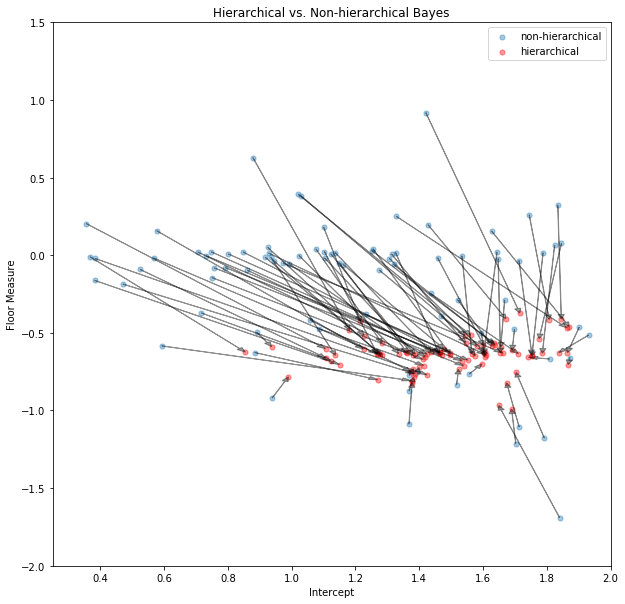

In [55]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, xlabel='Intercept', ylabel='Floor Measure', 
                     title='Hierarchical vs. Non-hierarchical Bayes', 
                     xlim=(0.25, 2), ylim=(-2, 1.5))

ax.scatter(indv_a,indv_b, s=26, alpha=0.4, label = 'non-hierarchical')
ax.scatter(hier_a,hier_b, c='red', s=26, alpha=0.4, label = 'hierarchical')
for i in range(len(indv_b)):  
    ax.arrow(indv_a[i], indv_b[i], hier_a[i] - indv_a[i], hier_b[i] - indv_b[i], 
             fc="k", ec="k", length_includes_head=True, alpha=0.4, head_width=.02)
ax.legend();

# Post 4 - *MCMC sampling for dummies*

## Bayes Formula
$$ P(\theta|x) = \frac{P(x|\theta)P(\theta)}{P(x)}
$$

In [ ]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
sns.set_style('white')
sns.set_context('talk')
np.random.seed(123)
np.__version__

In [ ]:
n_points = 20
data = np.random.randn(n_points)
data

In [ ]:
ax = plt.subplot()
sns.distplot(data, kde=True, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

- For **each** parameter to infer $\rightarrow$ chose a prior
$$\mu \sim Normal(0,1)$$

In [ ]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

In [ ]:
ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

In [ ]:
## Params
mu_current = 1.
proposal_width = 0.5
mu_prior_mu=0
mu_prior_sd=1.

In [ ]:
mu_proposal = norm(mu_current, proposal_width).rvs()
mu_proposal

In [ ]:
likelihood_current = norm(mu_current, 1).pdf(data).prod()
likelihood_current

In [ ]:
likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
likelihood_proposal

In [ ]:
# Compute prior probability of current and proposed mu        
prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
prior_current, prior_proposal

In [ ]:
# Nominator of Bayes formula
p_current = likelihood_current * prior_current
p_proposal = likelihood_proposal * prior_proposal
p_current, p_proposal

## Getting rid of the denominator by dividing posteriors

$$
\frac{\frac{P(x|\mu)P(\mu)}{P(x)}}
{\frac{P(x|\mu_{0})P(\mu_{0})}{P(x)}} 
= \frac{P(x|\mu)P(\mu)}{P(x|\mu_{0})P(\mu_{0})}
$$

In [ ]:
p_accept = p_proposal / p_current
accept = np.random.rand() < p_accept
print("Probability to Accept: {}".format(p_accept))
print("Accepted?:             {}".format(accept))

In [ ]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return np.array(posterior)

In [ ]:
# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

In [ ]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

In [ ]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

In [ ]:
ax = plt.subplot()

sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

In [ ]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

In [ ]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

In [ ]:
sns.distplot(posterior_small[1000:], label='Small step size')
sns.distplot(posterior_large[1000:], label='Large step size');
_ = plt.legend();

In [ ]:
from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [autocorr(posterior_large, l) for l in lags], label='large step size')
ax.plot(lags, [autocorr(posterior_small, l) for l in lags], label='small step size')
ax.plot(lags, [autocorr(posterior, l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

## Using PyMC3

In [ ]:
data.mean()

In [ ]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(15000, step)

In [ ]:
trace[2000:]['mu'].mean()

In [ ]:
sns.distplot(trace[2000:]['mu'], label='PyMC3 sampler');
sns.distplot(posterior[500:], label='Hand-written sampler');
plt.legend();

## Blog Idea

Use pyMC3 to calculate area of Mandelbrot set:
- Using importance sampling
- Using MCMC - Metropolis
- Using MCMC - Hamiltonian